#### Libraries Installation
!pip install outlier_utils
!pip install imbalanced-learn 
!pip install delayed
!pip install missingno
!pip install plotly
!pip install lightgbm
!pip install xgboost
!pip install category_encoders
!pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# access to the neural network model MLP Classifier
from sklearn.neural_network import MLPClassifier

# classification metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## TRAIN TEST SPLIT

In [ ]:
# Read Training Set
df = pd.read_csv('train.csv',dtype={
                             'ip': np.uint8,
                             'app': np.uint8,
                             'device' : np.uint8,
                             'os' : np.uint8,
                             'channel' : np.uint8,
                             'is_attributed' : np.uint8    
                        },parse_dates=['click_time'])

In [ ]:
df['day'] = df['click_time'].dt.day.astype('uint8')
# Get oot
#oot = df[df['day']==8]

# Get Train
df = df[df['day']==7]

In [ ]:
df['hour'] = df['click_time'].dt.hour.astype('uint8')
df['minute'] = df['click_time'].dt.minute.astype('uint8')
df['second'] = df['click_time'].dt.second.astype('uint8')

#Edit minute variable to two-digit string
df['minute'] = df['minute'].apply(lambda x: '{0:0>2}'.format(x))

In [ ]:
click_outlier = 14507.5
ratio_outlier = 812.8342105263157

In [ ]:
# Transform

ranges = [-1, 14, 29, 44, np.inf]  # np.inf for infinity
labels = ['1', '2', '3', '4']
df['seconds_grp'] = pd.cut(df['second'], 
                                  bins=ranges, 
                                  labels=labels)
df['interval'] = df['hour'].astype(str) + df['minute'].astype(str) + df['seconds_grp'].astype(str)
#df['interval'] = df['interval'].astype('uint32')

df_interval = df.groupby(
    'interval'
).aggregate(
    {
        'is_attributed':sum,
        'click_time':"count"
    }
).rename(
    columns = {
        'is_attributed': 'total_dl', 
        'click_time': 'total_clicks'
    }, 
    inplace = False)

df_interval['conversion_rate'] = df_interval['total_dl']/df_interval['total_clicks']
df_interval['ratio'] = df_interval['total_clicks']/df_interval['total_dl']
df_interval.reset_index(level=0, inplace=True)

df_interval.loc[(df_interval['total_dl'] == 0) & (df_interval['total_clicks'] > click_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['total_dl'] != 0) & (df_interval['ratio'] > ratio_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['isFraud'].isnull()), 'isFraud'] = 0

df = pd.merge(df, df_interval[['interval', 'isFraud']], on='interval', how='left')

df.head()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state = 280)

In [ ]:
print(train.isFraud.sum()/len(train))
print(test.isFraud.sum()/len(test))

In [ ]:
train = train.drop(["click_time","attributed_time", "is_attributed", "interval", "day", "hour", "minute", "second", "seconds_grp"], axis=1)
test = test.drop(["click_time","attributed_time", "is_attributed", "interval", "day", "hour", "minute", "second", "seconds_grp"], axis=1)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=280)

y_train = train['isFraud']
X_train = train.drop('isFraud', axis = 1)

X_train, y_train = rus.fit_resample(X_train, y_train)

from collections import Counter

Counter(y_train)

In [ ]:
X_train.to_csv('X_train_15s_full.csv', index=False)
y_train.to_csv('y_train_15s_full.csv', index=False)
test.to_csv('test_15s_full.csv', index=False)

In [ ]:
X_train.to_csv('X_train_15s.csv', index=False)
y_train.to_csv('y_train_15s.csv', index=False)
test.to_csv('test_15s.csv', index=False)

## Data Prep / Feature Engineering

In [2]:
# Read Data From Train-Test Split

X_train = pd.read_csv('X_train_15s.csv')
y_train = pd.read_csv('y_train_15s.csv')
test = pd.read_csv('test_15s.csv')

In [3]:
import category_encoders as ce
cat_features = ['ip', 'app', 'device', 'os', 'channel']
count_enc = ce.CountEncoder(cols=cat_features)
count_enc.fit(X_train)

X_train = X_train.join(count_enc.transform(X_train[cat_features]).add_suffix("_count"))
test = test.join(count_enc.transform(test[cat_features]).add_suffix("_count"))

In [4]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder(cols=cat_features, random_state=1234)
  
# Fit encoder and transform the features
cbe_encoder.fit(X_train[cat_features], y_train)

X_train = X_train.join(cbe_encoder.transform(X_train[cat_features]).add_suffix("_cb"))
test = test.join(cbe_encoder.transform(test[cat_features]).add_suffix("_cb"))

In [5]:
feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

In [6]:
X_train = X_train[feature_cols]
X_test = test[feature_cols]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

scaler.fit(X_test)

StandardScaler()

In [8]:
# Check event rate
print(y_train.sum()/len(y_train))
print(test.isFraud.sum()/len(test))

isFraud    0.5
dtype: float64
0.04242265494458271


## Modelling

In [10]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(test[feature_cols], label=test['isFraud'])

param = {'num_leaves': 180, 
         'max_bin': 64,
         'objective': 'binary', 
         'learning_rate': 0.1,
         'num_iterations': 200,
         'metric': 'auc', 
         'boosting': 'dart',
         'seed': 280}
lgbm_model = lgb.train(param, 
                       dtrain, 
                       num_boost_round=100, 
                       valid_sets=[dtest], 
                       early_stopping_rounds=5)

# save model
import joblib

joblib.dump(lgbm_model, 'lgb_count_cat_15s.pkl')

[LightGBM] [Info] Number of positive: 1771031, number of negative: 1771031
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 3542062, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's auc: 0.6183
[2]	valid_0's auc: 0.618722
[3]	valid_0's auc: 0.618938
[4]	valid_0's auc: 0.619086
[5]	valid_0's auc: 0.619235
[6]	valid_0's auc: 0.619317
[7]	valid_0's auc: 0.619568
[8]	valid_0's auc: 0.619618
[9]	valid_0's auc: 0.619727
[10]	valid_0's auc: 0.619851
[11]	valid_0's auc: 0.619911
[12]	valid_0's auc: 0.620035
[13]	valid_0's auc: 0.620058
[14]	valid_0's auc: 0.620114
[15]	valid_0's auc: 0.620179
[16]	valid_0's auc: 0.620188
[17]	valid_0's auc: 0.620245
[18]	va

NameError: name 'ypred_lgb' is not defined

### Train - Eval

In [12]:
# Prediction - Rounding-off Probability

ypred_lgb = lgbm_model.predict(X_train)
predictions_lgb = [round(value) for value in ypred_lgb]
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# evaluate predictions

print("accuracy: ",accuracy_score(y_train,predictions_lgb)*100)
print("auc: ",roc_auc_score(y_train,predictions_lgb)*100)
print("precision_score: ",precision_score(y_train,predictions_lgb)*100)
print("recall_score: ",recall_score(y_train,predictions_lgb)*100)

accuracy:  58.61272332330716
auc:  58.61272332330716
precision_score:  59.933198662670826
recall_score:  51.965945260133786


### Test - Eval

In [13]:
# Prediction - Rounding-off Probability
ypred_lgb = lgbm_model.predict(test[feature_cols])
predictions_lgb = [round(value) for value in ypred_lgb]
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# evaluate predictions

print("accuracy: ",accuracy_score(test['isFraud'],predictions_lgb)*100)
print("auc: ",roc_auc_score(test['isFraud'],predictions_lgb)*100)
print("precision_score: ",precision_score(test['isFraud'],predictions_lgb)*100)
print("recall_score: ",recall_score(test['isFraud'],predictions_lgb)*100)

accuracy:  64.40088042516282
auc:  58.33659466295457
precision_score:  6.137158371929478
recall_score:  51.710080230215524


### Checking Accuracy using a different decile threshold

In [15]:
X_train['prediction']=lgbm_model.predict(X_train)
X_train['decile'] = pd.qcut(X_train['prediction'], 10, labels=False)

In [32]:
# At top 2 Decile
X_train['predict_fraud'] = np.where(X_train['decile']>=8, 1, 0)

print("accuracy: ",accuracy_score(y_train,X_train['predict_fraud'])*100)
print("auc: ",roc_auc_score(y_train,X_train['predict_fraud'])*100)
print("precision_score: ",precision_score(y_train,X_train['predict_fraud'])*100)
print("recall_score: ",recall_score(y_train,X_train['predict_fraud'])*100)

accuracy:  78.655408082049
auc:  57.38694861257535
precision_score:  7.243137126664134
recall_score:  34.14665962176243


In [ ]:
test['prediction']=lgbm_model.predict(test[feature_cols])
test['decile'] = pd.qcut(test['prediction'], 10, labels=False)

In [ ]:
# At top 2 Decile
test['predict_fraud'] = np.where(test['decile']>=8, 1, 0)

print("accuracy: ",accuracy_score(test['isFraud'],test['predict_fraud'])*100)
print("auc: ",roc_auc_score(test['isFraud'],test['predict_fraud'])*100)
print("precision_score: ",precision_score(test['isFraud'],test['predict_fraud'])*100)
print("recall_score: ",recall_score(test['isFraud'],test['predict_fraud'])*100)

## Profiling

<AxesSubplot:xlabel='predict_fraud', ylabel='count'>

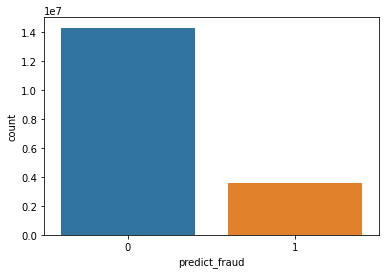

In [33]:
import seaborn as sns
sns.countplot(x='predict_fraud', data=test)

Plot feature importances...


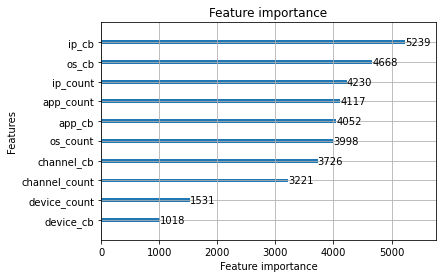

In [34]:
print('Plot feature importances...')
ax = lgb.plot_importance(lgbm_model, max_num_features=15)
plt.show()

In [ ]:
feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

In [47]:
profile_df = test.groupby('predict_fraud').agg({'ip_cb': ['mean'],
                                               'app_cb': ['mean'],
                                               'os_cb': ['mean'],
                                               'device_cb': ['mean'],
                                               'channel_cb': ['mean'],
                                               'ip_count': ['mean'],
                                               'app_count': ['mean'],
                                               'os_count': ['mean'],
                                               'device_count': ['mean'],
                                               'channel_count': ['mean']
                                               })

# rename columns
profile_df.columns = ['ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb','ip_count', 'app_count', 'device_count','os_count', 'channel_count']

# reset index to get grouped columns back
profile_df = profile_df.reset_index()



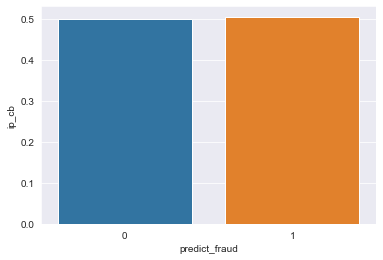

In [48]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "ip_cb", data = profile_df)
plt.show()

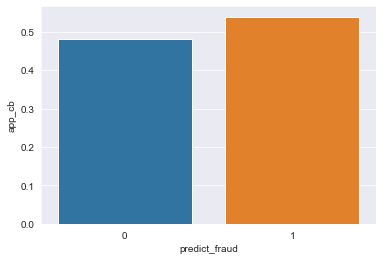

In [49]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "app_cb", data = profile_df)
plt.show()

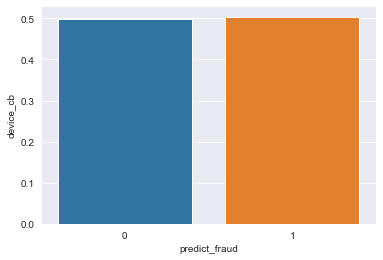

In [50]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "device_cb", data = profile_df)
plt.show()

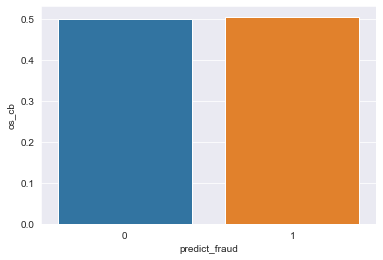

In [51]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "os_cb", data = profile_df)
plt.show()

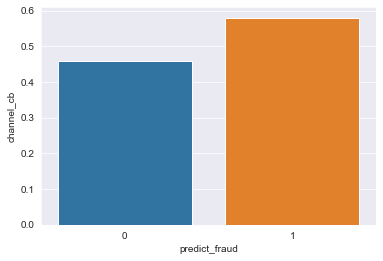

In [52]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "channel_cb", data = profile_df)
plt.show()

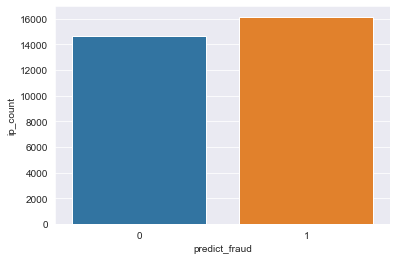

In [53]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "ip_count", data = profile_df)
plt.show()

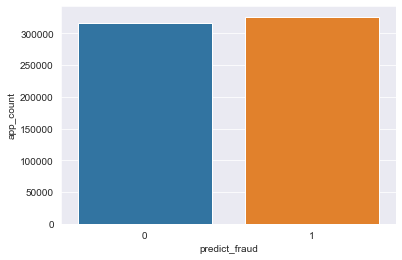

In [54]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "app_count", data = profile_df)
plt.show()

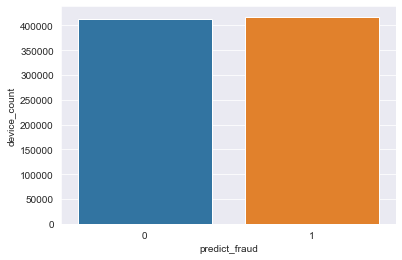

In [55]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "device_count", data = profile_df)
plt.show()

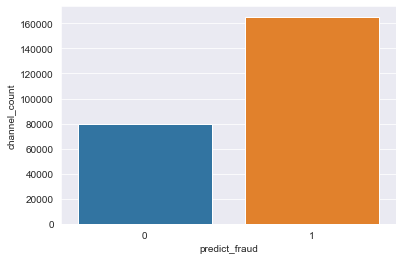

In [56]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "channel_count", data = profile_df)
plt.show()

## Model Explainer - SHAP

In [ ]:
import joblib
lgbm_model = joblib.load('lgb_count_cat_15s.pkl')

feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

X_train = X_train[feature_cols]
X_test = test[feature_cols]

In [ ]:
X_train

In [ ]:
import shap

%time shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_test)


In [ ]:
shap.summary_plot(shap_values, valid_x)
